这个笔记本使用原生 Python 绑定，为 MuJoCo 物理提供了一个入门教程
摘自：https://github.com/google-deepmind/mujoco/blob/main/python/tutorial.ipynb

# All imports

In [4]:
# !pip install mujoco

# Set up GPU rendering.
# from google.colab import files
import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
    raise RuntimeError(
        'Cannot communicate with GPU. '
        'Make sure you are using a GPU Colab runtime. '
        'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
    with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
        f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

# Check if installation was succesful.
try:
    print('Checking that the installation succeeded:')
    import mujoco
    mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
    raise e from RuntimeError(
        'Something went wrong during installation. Check the shell output above '
        'for more information.\n'
        'If using a hosted Colab runtime, make sure you enable GPU acceleration '
        'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

# Other imports and helper functions
import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()


# Tendons, actuators and sensors 肌腱、执行器和传感器

""

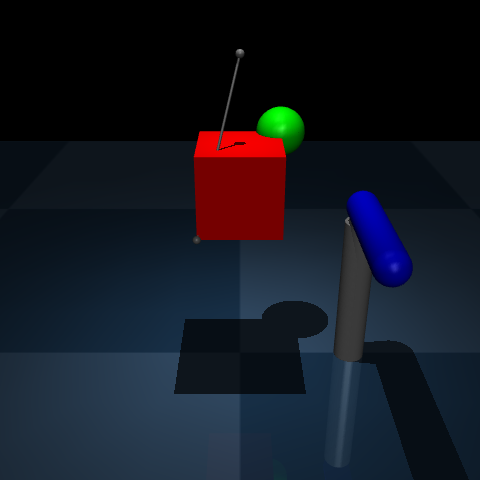

In [5]:
MJCF = """
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>
    <site name="anchor" pos="0 0 .3" size=".01"/>
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>
    </body>

    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>
      <site name="IMU"/>
    </body>
  </worldbody>

  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>

  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
"""
<mujoco>
  <asset>
    <texture name="grid" type="2d" builtin="checker" rgb1=".1 .2 .3"
     rgb2=".2 .3 .4" width="300" height="300" mark="none"/>  # 定义棋盘格纹理
    <material name="grid" texture="grid" texrepeat="1 1"
     texuniform="true" reflectance=".2"/>  # 定义地面材质
  </asset>

  <worldbody>
    <light name="light" pos="0 0 1"/>  # 灯光
    <geom name="floor" type="plane" pos="0 0 -.5" size="2 2 .1" material="grid"/>  # 地面
    <site name="anchor" pos="0 0 .3" size=".01"/>  # 用作tendon锚点
    <camera name="fixed" pos="0 -1.3 .5" xyaxes="1 0 0 0 1 2"/>  # 摄像机视角

    <geom name="pole" type="cylinder" fromto=".3 0 -.5 .3 0 -.1" size=".04"/>  # 小柱子

    # 蝙蝠（棒子）
    <body name="bat" pos=".3 0 -.1">
      <joint name="swing" type="hinge" damping="1" axis="0 0 1"/>  # 可摆动关节
      <geom name="bat" type="capsule" fromto="0 0 .04 0 -.3 .04"
       size=".04" rgba="0 0 1 1"/>  # 蓝色胶囊棒子
    </body>

    # 带箱子和小球的自由体
    <body name="box_and_sphere" pos="0 0 0">
      <joint name="free" type="free"/>  # 自由关节
      <geom name="red_box" type="box" size=".1 .1 .1" rgba="1 0 0 1"/>  # 红色立方体
      <geom name="green_sphere"  size=".06" pos=".1 .1 .1" rgba="0 1 0 1"/>  # 绿色小球
      <site name="hook" pos="-.1 -.1 -.1" size=".01"/>  # 软体或绳索挂点
      <site name="IMU"/>  # 传感器挂点
    </body>
  </worldbody>

  # tendon系统：模拟伸缩连接
  <tendon>
    <spatial name="wire" limited="true" range="0 0.35" width="0.003">
      <site site="anchor"/>
      <site site="hook"/>
    </spatial>
  </tendon>

  # actuator系统：用于驱动蝙蝠关节
  <actuator>
    <motor name="my_motor" joint="swing" gear="1"/>
  </actuator>

  # 传感器：IMU加速度计
  <sensor>
    <accelerometer name="accelerometer" site="IMU"/>
  </sensor>
</mujoco>
"""
model = mujoco.MjModel.from_xml_string(MJCF)  # 从XML字符串加载模型
data = mujoco.MjData(model)  # 创建仿真数据结构
height = 480
width = 480

# 渲染并展示
with mujoco.Renderer(model, height, width) as renderer:
  mujoco.mj_forward(model, data)  # 初始化位置和姿态
  renderer.update_scene(data, "fixed")  # 使用固定摄像机视角更新场景

  media.show_image(renderer.render())  # 显示当前帧

In [6]:
# 相关参数
n_frames = 180  # 总帧数
height = 240  # 渲染高度（像素）
width = 320  # 渲染宽度（像素）
frames = []  # 存储所有渲染帧
fps = 60.0  # 帧率
times = []  # 存储仿真时间戳
sensordata = []  # 存储加速计数据

# constant actuator signal  # 恒定的执行器信号
mujoco.mj_resetData(model, data)  # 初始化仿真状态
data.ctrl = 20  # 直接施加恒定的电机控制信号

# Simulate and display video.  # 模拟并显示视频
with mujoco.Renderer(model, height, width) as renderer:
  for i in range(n_frames):
    while data.time < i/fps:  # 持续推进仿真直到当前帧时间点
      mujoco.mj_step(model, data)  # 单步仿真
      times.append(data.time)  # 记录仿真时间
      sensordata.append(data.sensor('accelerometer').data.copy())  # 记录加速度传感器数据
    renderer.update_scene(data, "fixed")  # 使用固定摄像机视角
    frame = renderer.render()  # 渲染当前帧
    frames.append(frame)  # 存储帧

# 显示视频
media.show_video(frames, fps=fps)

['axis x', 'axis y', 'axis z']


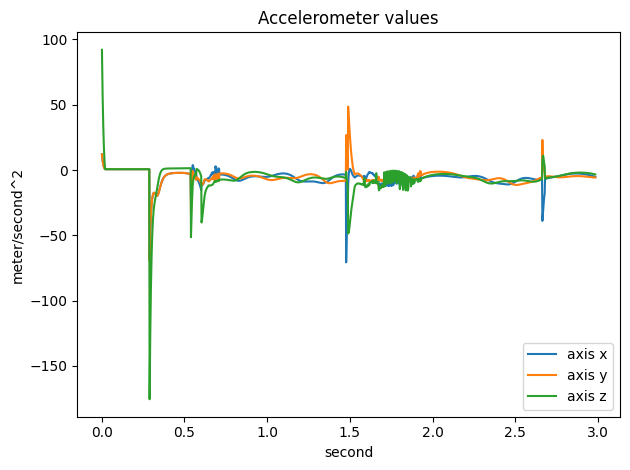

In [7]:
ax = plt.gca()  # 获取当前坐标轴

# 绘制加速度计数据
ax.plot(np.asarray(times), np.asarray(sensordata), label=[f"axis {v}" for v in ['x', 'y', 'z']])
label=[f"axis {v}" for v in ['x', 'y', 'z']]
print(label)
# sensordata_array = np.asarray(sensordata)
# ax.plot(times, sensordata_array[:,0], label='x')
# ax.plot(times, sensordata_array[:,1], label='y')
# ax.plot(times, sensordata_array[:,2], label='z')

# finalize plot  # 最终绘图
ax.set_title('Accelerometer values')
ax.set_ylabel('meter/second^2')
ax.set_xlabel('second')
ax.legend(frameon=True, loc='lower right')
plt.tight_layout()